# Movie Recommendation Using NLP

### Import necessary libraries

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import io
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from skimage import io
from IPython.display import clear_output
pd.set_option('display.max_colwidth', None)
import networkx as nx
from wordcloud import WordCloud

## Data Preprocessing

In [16]:
# read the dataset https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies
df = pd.read_csv('movies.csv')

In [17]:
# drop movies that have a short description
df['word_count'] = df['overview'].apply(lambda x: len(str(x).split()))
df = df[df['word_count'] >= 50]
df.drop('word_count', axis=1, inplace=True)

In [18]:
# drop all duplicates
df.drop_duplicates(subset=['title', 'release_date'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [19]:
# Drop rows with missing poster_path
df.dropna(subset=['poster_path'], inplace=True)

In [20]:
# fill empty cells
df.fillna(value={i: '' for i in ['overview', 'genres', 'keywords', 'credits']}, inplace=True)

In [23]:
# drop movies with low vote count
df.drop(df[df.vote_count < 100].index, inplace=True)

In [26]:
# lambda function to preprocess string data
strOp= lambda x: ' '.join(x.split('-'))

In [27]:
# set overview to lowercase and remove punctuation
df.overview = df.overview.str.lower()
df.overview = df.overview.str.replace(r'[^\w\s]+', '')

C:\Users\Janika\AppData\Local\Temp\ipykernel_19392\833376294.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df.overview = df.overview.str.replace(r'[^\w\s]+', '')


In [28]:
# add keywords, genres and credits to overview for full information
df.overview = df.overview + df.keywords.apply(strOp) + df.genres.apply(strOp) + df.credits.apply(lambda x: ' '.join(x.replace(' ', '').split('-')[:3]))
# example
df.overview[0]

'set more than a decade after the events of the first film learn the story of the sully family jake neytiri and their kids the trouble that follows them the lengths they go to keep each other safe the battles they fight to stay alive and the tragedies they endureloss of loved one dying and death alien life form resurrection sequel dysfunctional family alien planet distant future adopted child rebirth family dynamics adopted son stronger villain warScience Fiction Adventure ActionSamWorthington ZoeSaldaña SigourneyWeaver'

## Data Analysis

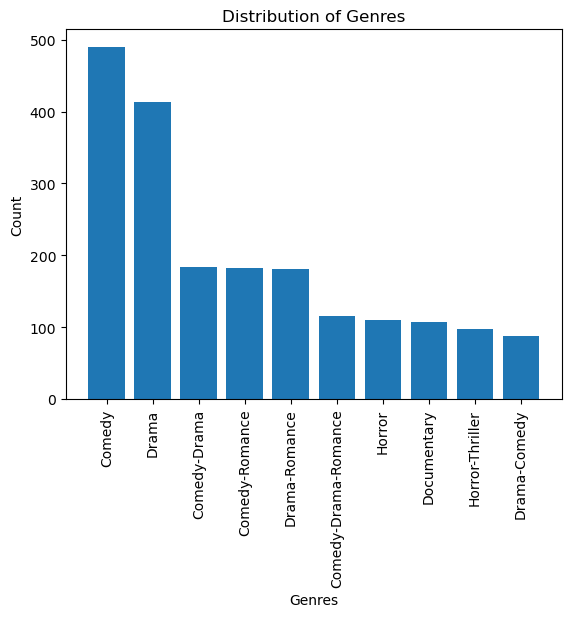

In [29]:
# Bar chart for genres
genre_counts = df['genres'].value_counts().head(10)
plt.bar(genre_counts.index, genre_counts.values)
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Distribution of Genres')
plt.xticks(rotation=90)
plt.show()

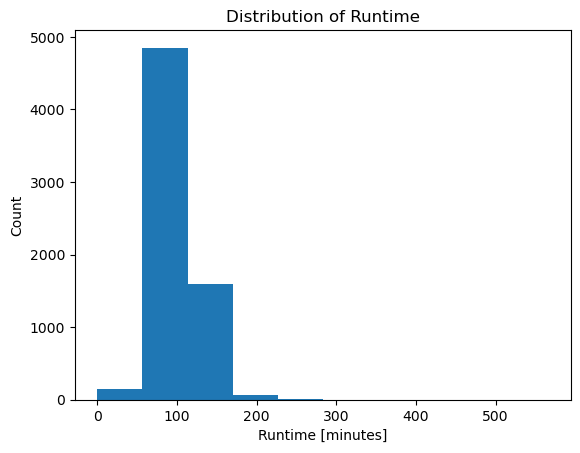

In [32]:
# Histogram for movie runtimes
plt.hist(df['runtime'], bins=10)
plt.xlabel('Runtime [minutes]')
plt.ylabel('Count')
plt.title('Distribution of Runtime')
plt.show()

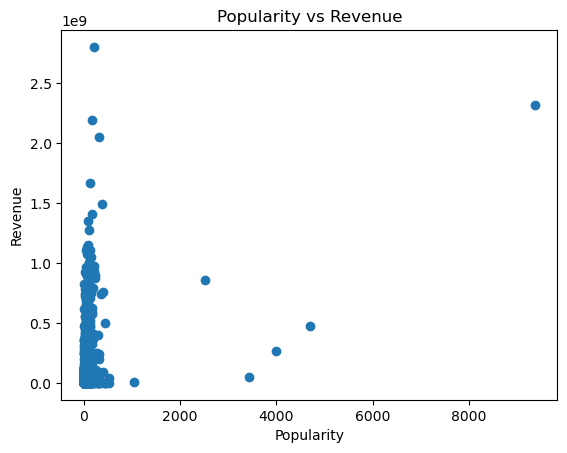

In [30]:
# Scatter plot for popularity and revenue
plt.scatter(df['popularity'], df['revenue'])
plt.xlabel('Popularity')
plt.ylabel('Revenue')
plt.title('Popularity vs Revenue')
plt.show()

In [6]:
# drop movies with low vote count
df.drop(df[df.vote_count < 100].index, inplace=True)

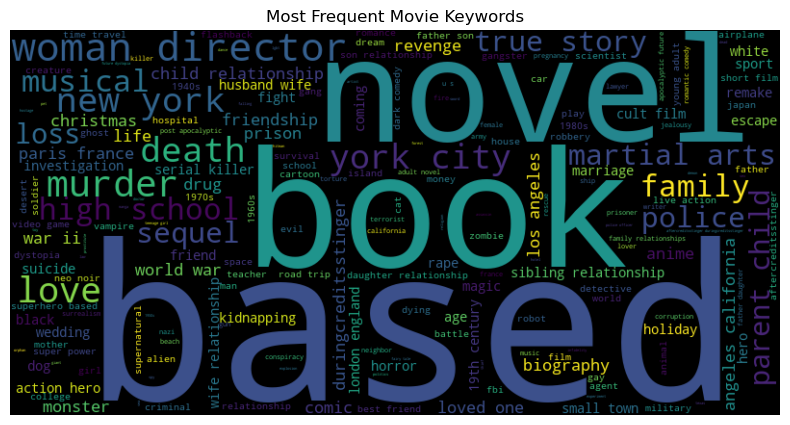

In [34]:
# Word cloud for movie keywords
keywords_text = ' '.join(df['keywords'].dropna().values)
wordcloud = WordCloud(width=800, height=400).generate(keywords_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Movie Keywords')
plt.show()

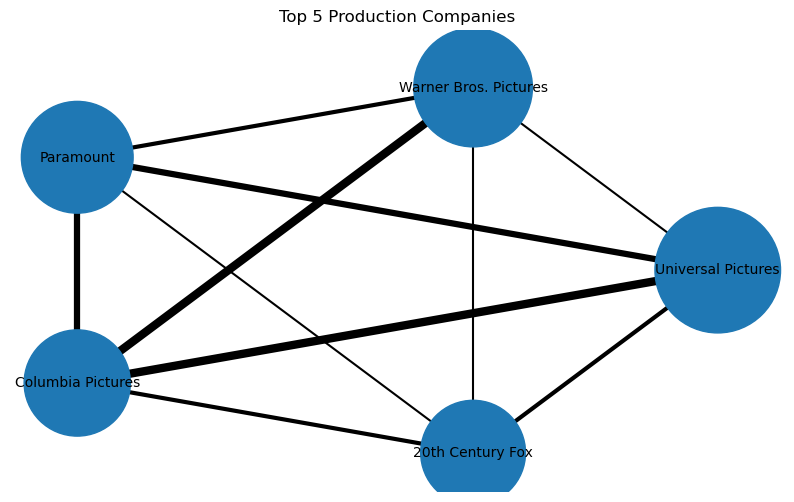

In [76]:
G = nx.Graph()

production_companies = df['production_companies'].str.split('-', expand=True).values.flatten()
production_companies = [company.strip() for company in production_companies if isinstance(company, str) and company.strip()]
company_counts = pd.Series(production_companies).value_counts().head(5)
G.add_nodes_from(company_counts.index)

# Add edges between production companies
for row in df.itertuples():
    companies = str(row.production_companies).split('-')  # Convert to string and split
    companies = [company.strip() for company in companies if isinstance(company, str) and company.strip()]
    if len(companies) > 1:
        for i in range(len(companies)):
            for j in range(i+1, len(companies)):
                if G.has_edge(companies[i], companies[j]):
                    G[companies[i]][companies[j]]['weight'] += 1  # Increase weight if edge already exists
                elif companies[i] in G.nodes and companies[j] in G.nodes:
                    G.add_edge(companies[i], companies[j], weight=1)  # Add edge with weight=1

plt.figure(figsize=(10, 6))
pos = nx.circular_layout(G)
node_size = [company_counts.get(node, 0)*25 for node in G.nodes()]
edge_width = [1.5 * G[u][v]['weight'] for u, v in G.edges()]  # Use the 'weight' attribute for edge width
nx.draw_networkx(G, pos=pos, with_labels=True, node_size=node_size, font_size=10, width=edge_width)
plt.title('Top 5 Production Companies')
plt.axis('off')
plt.show()

In [70]:
# Filter rows where both "Universal Pictures" and "Columbia Pictures" are production companies
movies = df[df['production_companies'].str.contains('Universal Pictures') & df['production_companies'].str.contains('Columbia Pictures')]

# Display the movie titles
movie_titles = movies['title'].tolist()
for title in movie_titles:
    print(title)


Peter Pan
The Bone Collector
The Rundown
The Electric Horseman


In [61]:
# Iterate over the rows of the DataFrame
for row in df.itertuples():
    cozmpanies = str(row.production_companies).split('-')  # Convert to string and split
    companies = [company.strip() for company in companies if isinstance(company, str) and company.strip()]
    
    # Check if both "Warner Bros. Pictures" and "Paramount" are present in the production companies
    if "Warner Bros. Pictures" in companies and "Paramount" in companies:
        print(row)
        break


Pandas(Index=635, id=4922, title='The Curious Case of Benjamin Button', genres='Drama-Fantasy-Romance', original_language='en', overview='i was born under unusual circumstances and so begins the curious case of benjamin button adapted from the 1920s story by f scott fitzgerald about a man who is born in his eighties and ages backwards a man like any of us who is unable to stop time we follow his story set in new orleans from the end of world war i in 1918 into the 21st century following his journey that is as unusual as any mans life can be benjamin button is a grand tale of a notsoordinary man and the people and places he discovers along the way the loves he finds the joys of life and the sadness of death and what lasts beyond timediary navy funeral tea travel hospital based on short story reverse agingDrama Fantasy RomanceBradPitt CateBlanchett TarajiP.Henson', popularity=44.56, production_companies='Paramount-Warner Bros. Pictures-The Kennedy/Marshall Company', release_date='2008-12

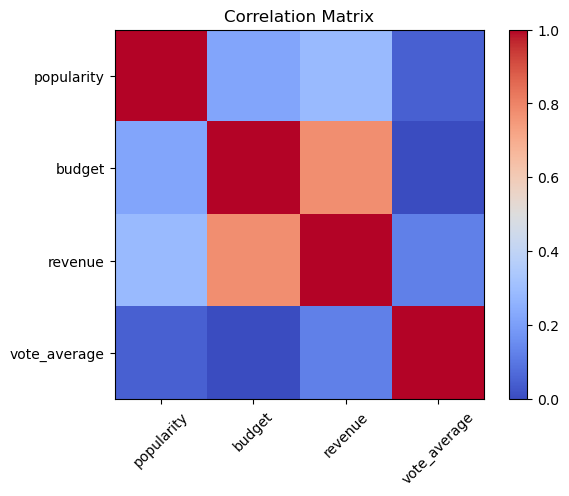

In [39]:
# Heatmap for correlation matrix
corr_matrix = df[['popularity', 'budget', 'revenue', 'vote_average']].corr()
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(corr_matrix.shape[1]), corr_matrix.columns, rotation=45)
plt.yticks(range(corr_matrix.shape[1]), corr_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

### Initialize the TF-IDF Vectorizer to transform text data into vectors

In [ ]:
# lambda function to preprocess string data
strOp= lambda x: ' '.join(x.split('-'))

#### only run these lines once!

In [ ]:
# TF-IDF Vectorizer to transform words into numbers and remove common english words like 'the'
tfidf = TfidfVectorizer(stop_words='english')

In [ ]:
# transform overview data with TF-IDF vectorizer to create matrix
tfidf_matrix = tfidf.fit_transform(df['overview'])

In [ ]:
#display some columns with vectorized words
display(pd.DataFrame(
    tfidf_matrix[:5, 10000:10005].toarray(),
    columns= tfidf.get_feature_names_out()[10000:10005],
    index = df.title[:5]).round())

print(tfidf_matrix.shape)
# over 970000 different words used to describe all movies

## Movie Recommendation

### Initialize the recommendation function

In [ ]:
def get_recommendation(user_input, choice):
    # Vectorize user input
    vectorized_input = tfidf.transform([user_input])

    # Calculate cosine similarity between user input and movie overviews
    similarity_scores = cosine_similarity(vectorized_input, tfidf_matrix)

    # Get the indices of top similar movies
    top_indices = similarity_scores.argsort()[0][::-1][:50]

    # Retrieve the top recommended movies
    recommended_movies = df.iloc[top_indices]
    
    # Sort movies based on vote_average and get the top 3 highest rated movies\n",
    top_rated_movies = recommended_movies.sort_values(by='vote_average', ascending=False).iloc[:3]
    
    # Sort movies based on popularity and get the top 3 most popular movies\n",
    most_popular_movies = recommended_movies.sort_values(by='popularity', ascending=False).iloc[:3]
    
    # Initialize the figure
    fig, ax = plt.subplots(1, 3, figsize=(20, 20))
    ax = ax.flatten()
    
    if choice == 'Our Recommendation':
        # Display movie posters for the recommended movies
        for i, j in enumerate(recommended_movies.poster_path):
            try:
                ax[i].axis('off')
                ax[i].set_title(recommended_movies.iloc[i].title, fontsize=22)
                a = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
                ax[i].imshow(a)
            except:
                pass
        fig.tight_layout()
        plt.show()
        print()
        print("Recommended Movies:")
        print(recommended_movies[['title', 'overview']].head(3))
    
    elif choice == 'Top Rated Movies':
        # Display highest rated movies
        for i, j in enumerate(top_rated_movies.poster_path):
                try:
                    ax[i].axis('off')
                    ax[i].set_title(top_rated_movies.iloc[i].title, fontsize=22)
                    a = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
                    ax[i].imshow(a)
                except:
                    pass
        fig.tight_layout()
        plt.show()
        print()
        print("Highest Rated Movies:")
        print(top_rated_movies[['title', 'overview']].head(3))
    
    elif choice == 'Most Popular Movies':
        # Display most popular movies\n",
        for i, j in enumerate(most_popular_movies.poster_path):
            try:
                ax[i].axis('off')
                ax[i].set_title(most_popular_movies.iloc[i].title, fontsize=22)
                a = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
                ax[i].imshow(a)
            except:
                pass
        fig.tight_layout()
        plt.show()
        print()
        print("Most Popular Movies:")
        print(most_popular_movies[['title', 'overview']].head(3))
    
    else:
        print('mistake')

### Ask for User Input

In [ ]:
def get_genres():
    genres = input("What Movie Genre are you interested in (if multiple, please separate them with a comma)? [Type 'skip' to skip this question] ")
    genres = " ".join(["".join(n.split()) for n in genres.lower().split(',')])
    return genres

def get_overview():
    overview = input("What should the movie be about [Type 'skip' to skip this question]")
    overview = overview.lower()
    overview = overview.replace(r'[^\w\s]+', '')
    return overview
    
def get_searchTerms():
    searchTerms = [] 
    genres = get_genres()
    if genres != 'skip':
        searchTerms.append(genres)

    overview = get_overview()
    if overview != 'skip':
        searchTerms.append(overview)
    
    searchTerms = " ".join(searchTerms)
    
    choice = widgets.Dropdown(
        options=['Our Recommendation', 'Top Rated Movies', 'Most Popular Movies'],
        description='Choose a Search Option:',
        layout={'width': '600px'}
    )
    choice.style.description_width = '250px'
    display(choice)
    
    return searchTerms, choice.value


In [ ]:
user_input, choice = get_searchTerms()

### Show Recommendations

In [ ]:
get_recommendation(user_input, choice)